# How to find and Plot Level 2 Data from Multiple Granules on a Map using Python

### 1. Import Libraries

In [10]:
import glob
import numpy as np
import netCDF4
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import platform
import requests

### 2. Extract URLs from the CMR and Download Granules

To search for URLs of the granules of interest, we perform a CMR query using the ShortName (SNDRJ1IML2CCPRET) and VersionID of the dataset as well as the time range and bounding box of the time and region of interest. These URLs will be stored in a list for downloading.

In [11]:
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules'

# CMR API query
cmr_response = requests.get(cmr_url, 
                            params={
                                'short_name': 'SNDRJ1IML2CCPRET',
                                'version': '2',
                                'temporal': '2021-09-23T00:00:00Z,2021-09-24T00:00:00Z',
                                'bounding_box': "-100,15,-75,30",
                                'page_size': 200,
                                },
                            headers={
                                'Accept': 'application/json'
                                }
                            )

# Create a list of the data URLs.
listofurls = []
for i in range(len(cmr_response.json()['feed']['entry'])):
    link = cmr_response.json()['feed']['entry'][i]['links'][0]['href']
    print(link)
    listofurls.append(link)

https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0606.m06.g062.L2_CLIMCAPS_RET.std.v02_53.G.211223053311.nc
https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0612.m06.g063.L2_CLIMCAPS_RET.std.v02_53.G.211223053331.nc
https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0748.m06.g079.L2_CLIMCAPS_RET.std.v02_53.G.211223053551.nc
https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0754.m06.g080.L2_CLIMCAPS_RET.std.v02_53.G.211223053611.nc
https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1724.m06.g175.L2_CLIMCAPS_RET.std.v02_53.G.211223055024.nc
https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.202109

The following block of code used wget to downloas the Level 2 files in the region of interest to the current directory

In [12]:
""" listofurls = ['https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0606.m06.g062.L2_CLIMCAPS_RET.std.v02_53.G.211223053311.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0612.m06.g063.L2_CLIMCAPS_RET.std.v02_53.G.211223053331.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0748.m06.g079.L2_CLIMCAPS_RET.std.v02_53.G.211223053551.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0754.m06.g080.L2_CLIMCAPS_RET.std.v02_53.G.211223053611.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1724.m06.g175.L2_CLIMCAPS_RET.std.v02_53.G.211223055024.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1900.m06.g191.L2_CLIMCAPS_RET.std.v02_53.G.211223055205.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1906.m06.g192.L2_CLIMCAPS_RET.std.v02_53.G.211223055225.nc'] """

fname='dataurls.txt'
f = open(fname,'w')
for url in listofurls:
    f.write(url+'\n')
f.close()

os.system('wget -i dataurls.txt')


0

### 3. Aggregate and Plot

The following block of code reads the names of the local netcdf files and plots the surface Air Temperature from the first file in the list.

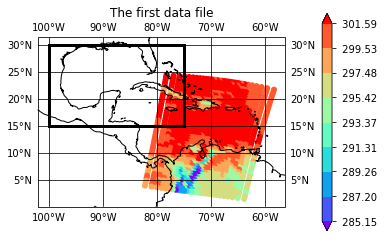

In [13]:
# glob will read in the relevant datafiles to plot.
datafiles = glob.glob('*.nc')

# these are the relevant science variable
varname = 'surf_air_temp'
qcvarname =  'surf_air_temp_qc'

# this reads the data from the first file in the 
fid = netCDF4.Dataset(datafiles[0] ,mode='r',format='NETCDF4')
lat = fid.variables['lat'][:]
lon = fid.variables['lon'][:]
sol_zen = fid.variables['sol_zen'][:] # this variable will be used to separate the day from the night 
data = fid.variables[varname][:]
dataqc = fid.variables[qcvarname][:]

# this sets up the plot
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='black')
lowerlimit = data.min()
upperlimit = data.max()
ncolors=10
cmap=plt.cm.rainbow
bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
c=plt.scatter(lon,lat,c=data, cmap=cmap, norm=norm, edgecolor='black', linewidth=0)
plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")


bb = ((-100, 15),(-75, 30)) # this is the bounding box indicating the lower left and upper right pairs of Longitude and Latitude

# the following lines plot a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=3,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=3,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=3,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=3,transform=ccrs.PlateCarree())

plt.title('The first data file')

plt.show()
fid.close()

The next step is to loop over all of the data files to aggregate the data to be plotted.

In [14]:
# initialize the array into which the data will be aggregated.
lon_agg = np.array([])
lat_agg = np.array([])
sol_zen_agg = np.array([])
data_agg = np.array([])
dataqc_agg = np.array([])

for i,file in enumerate(datafiles):
    # open the file
    fid = netCDF4.Dataset( file ,mode='r',format='NETCDF4')

    # read the longitude, latitude, and other relevant variables
    lat = fid.variables['lat'][:]
    lon = fid.variables['lon'][:]
    sol_zen = fid.variables['sol_zen'][:]
    data = fid.variables[varname][:]
    dataqc = fid.variables[qcvarname][:]
    
    lon_agg = np.append(lon_agg,lon.flatten().copy())
    lat_agg = np.append(lat_agg,lat.flatten().copy())
    sol_zen_agg = np.append(sol_zen_agg,sol_zen.flatten().copy())
    data_agg = np.append(data_agg,data.flatten().copy()) 
    dataqc_agg = np.append(dataqc_agg,dataqc.flatten().copy()) 

The following block of code plots all of the aggregated data.

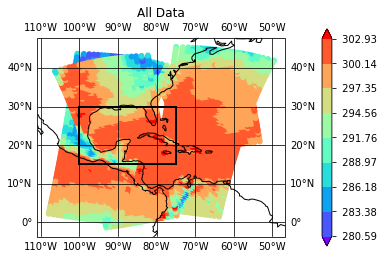

In [15]:
# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg,lat_agg,c=data_agg, cmap=cmap, norm=norm, edgecolor='black', linewidth=0)

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('All Data')

# the following lines plot a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()


Since some satellite observations from different orbits may be on top of each other, only the most recently symbol plotted may be visible in the figure.  Therefore, plotting smaller symbols may make it easier to distiguish individual footprints.

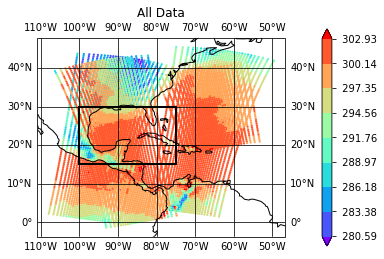

In [27]:
# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg,lat_agg,c=data_agg, cmap=cmap, norm=norm, edgecolor='black', linewidth=0, s=5) # s=5 will make the symbols smaller

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('All Data with smaller points')

# the following lines plot a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()


The above figure shows that, even with smaller symbols, it is difficult to distingush individual between daytime and nightime observations when the orbits are overlaid. The following example shows that we can use the solar zenith angle variable to only select the daytime observation (i.e., when sol_zen_agg < 90).

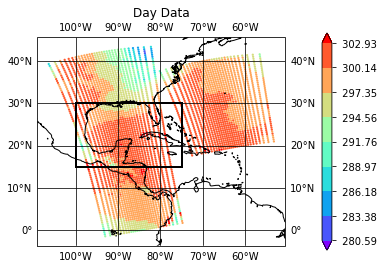

In [28]:
daymask = sol_zen_agg < 90.

# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[daymask],lat_agg[daymask],c=data_agg[daymask], norm=norm, cmap=cmap, edgecolor='black', linewidth=0, s=5)

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Day Data')

# the following lines plot a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()

Now just plot the nighttime footprints

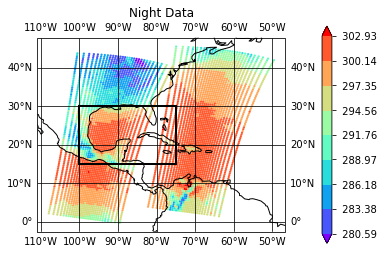

In [29]:
nightmask = sol_zen_agg >= 90

# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[nightmask],lat_agg[nightmask],c=data_agg[nightmask], cmap=cmap, norm=norm, edgecolor='black', linewidth=0, s=5)

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Night Data')

# the following lines plot a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()

The next block of code uses the solar zenith angle and the quality flag to create a mask that will just plot the good data at night.  

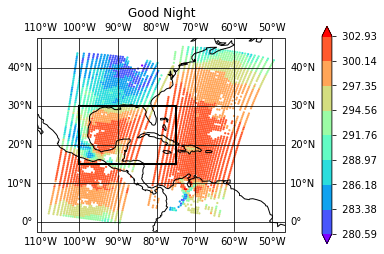

In [30]:
gooddatamask = np.logical_or(dataqc_agg == 0, dataqc_agg == 1)

nightmask = sol_zen_agg >= 90

goodnightmask = np.logical_and(gooddatamask,nightmask)


# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[goodnightmask],lat_agg[goodnightmask],c=data_agg[goodnightmask], cmap=cmap, norm=norm, edgecolor='black', linewidth=0, s=5)

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Good Night')

# the following lines plot a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()

By selecting only the coordinates within the bounding box we can plot slightly larger symbols and still see individual footprints.

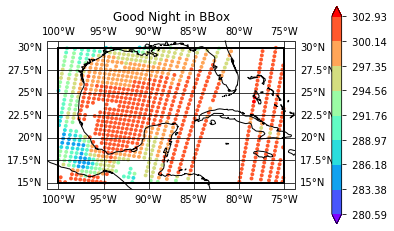

In [33]:
gooddatamask = np.logical_or(dataqc_agg == 0, dataqc_agg == 1)
nightmask = sol_zen_agg >= 90

goodnightmask = np.logical_and(gooddatamask,nightmask)

inbbox = np.logical_and(np.logical_and(lon_agg > bb[0][0],lon_agg < bb[1][0]),
                        np.logical_and(lat_agg > bb[0][1],lat_agg < bb[1][1]))

goodnightinbboxmask = np.logical_and(goodnightmask,inbbox)

# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[goodnightinbboxmask],lat_agg[goodnightinbboxmask],c=data_agg[goodnightinbboxmask], cmap=cmap, norm=norm, edgecolor='black', linewidth=0, s=15)

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Good Night in BBox')

# the following lines plot a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()